# PySPTKによる音声の分析再合成 (LPC係数による全極フィルタ)

In [1]:
from pysptk.synthesis import AllPoleDF, Synthesizer
from scipy.io import wavfile
import librosa
import numpy as np
import pysptk
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
# 音声の分析条件
FRAME_LENGTH = 1024 # フレーム長 (point)
HOP_LENGTH = 80 # フレームシフト (point)
MIN_F0 = 60 # 基本周波数の最小値 (Hz)
MAX_F0 = 240 # 基本周波数の最大値 (Hz)
ORDER = 20 # LPCの分析次数

In [3]:
IN_WAVE_FILE = "in.wav"       # 入力音声
OUT_WAVE_FILE = "out.wav"     # 分析再合成した音声

In [4]:
# 音声の読み込み
fs, x = wavfile.read(IN_WAVE_FILE)
x = x.astype(np.float64)

In [5]:
# 音声の切り出しと窓掛け
frames = librosa.util.frame(x, frame_length=FRAME_LENGTH,
                            hop_length=HOP_LENGTH).astype(np.float64).T
frames *= pysptk.blackman(FRAME_LENGTH)  # 窓掛け（ブラックマン窓）

In [6]:
# ピッチ抽出
pitch = pysptk.swipe(x, fs=fs, hopsize=HOP_LENGTH,
                     min=MIN_F0, max=MAX_F0, otype="pitch")

In [7]:
# 励振源信号(声帯音源)の生成
source_excitation = pysptk.excite(pitch, HOP_LENGTH)

In [8]:
# 線形予測分析による線形予測係数の抽出
lpc = pysptk.lpc(frames, ORDER)
lpc[:, 0] = np.log(lpc[:, 0])  # 対数ゲイン for AllPoleDF

In [9]:
# 全極フィルタの作成
synthesizer = Synthesizer(AllPoleDF(order=ORDER), HOP_LENGTH)

In [10]:
# 励振源信号でフィルタを駆動して音声を合成
y = synthesizer.synthesis(source_excitation, lpc)

In [11]:
# 音声の書き込み
y = y.astype(np.int16)
wavfile.write(OUT_WAVE_FILE, fs, y)

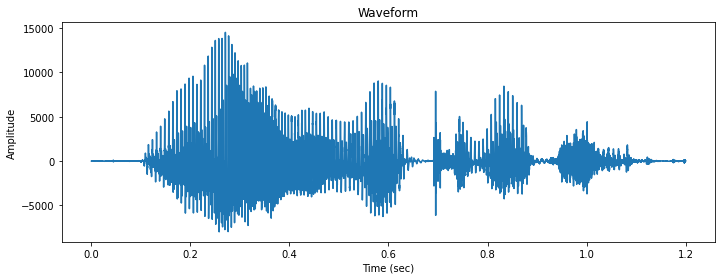

In [12]:
# オリジナルの音声をプロット
n_samples = len(x)
time = np.arange(n_samples) / fs # 時間軸の設定

# プロット枠を確保 (10がヨコのサイズ、4はタテのサイズ)
plt.figure(figsize=(10, 4))

# x軸のラベル
plt.xlabel("Time (sec)")

# y軸のラベル
plt.ylabel("Amplitude")

# 画像のタイトル
plt.title("Waveform")

# 余白を最小化
plt.tight_layout()

# 波形のプロット
plt.plot(time, x)

In [13]:
x = x.astype(np.int16)
Audio(x, rate=fs) # オリジナルの音声

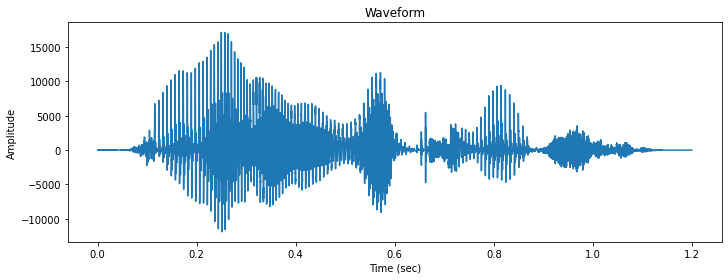

In [14]:
# 分析再合成した音声をプロット
n_samples = len(y)
time = np.arange(n_samples) / fs # 時間軸の設定

# プロット枠を確保 (10がヨコのサイズ、4はタテのサイズ)
plt.figure(figsize=(10, 4))

# x軸のラベル
plt.xlabel("Time (sec)")

# y軸のラベル
plt.ylabel("Amplitude")

# 画像のタイトル
plt.title("Waveform")

# 余白を最小化
plt.tight_layout()

# 波形のプロット
plt.plot(time, y)

In [15]:
Audio(y, rate=fs) # 再合成した音声